## What is this notebook for?
The purpose of this notebook is to provide information on histograms as applied to spatial imagery data like DEMs and spectral indices. Image histograms visually summarize the distribution of a continuous numeric variable by measuring the frequency at which certain values appear in the image. The x-axis in the image histogram is a number line that displays the range of image pixel values that has been split into number ranges, or bins.

This notebook will also investigate some potential methods for binning pixels from a raster. The example in this notebook will be a DEM, and maybe an NDVI.

**histograms:** Histogram is a common non-parametric graphical representation tool used to display and summarize information about data.

Binning is a way of simplifying the information the user interacts with - because there can be a lotof variability across all of the pixels, but grouping pixels within ranges (e.g. 0-5%, 5-10%) is a way of reducing noise and getting a better idea of overall trend.

<img src="/workspace/notebooks/sandbox/landscape/oscar.png" alt="Not that kind of binning" style="width: 400px;"/>

## Binning techniques to explore:

**Equal-width binning:** Dividing the range of data into bins of equal size. This method is straightforward but might not work well with skewed data distributions.

**Equal-frequency (quantile) binning:** Binning data so that each bin has approximately the same number of pixels. This can help in handling outliers and skewed data.

**Adaptive binning:** Techniques like k-means clustering to create bins that are more adapted to the data distribution.

**Data-driven thresholds:** Natural breaks (e.g. Jenks optimization) which are popular in spatial data visualization to define bins that minimize variance within bins and maximize variance between bins.

**Non-linear transformations:** Useful if the data spans several orders of magnitude or is skewed (not normally distributed), which is common for elevation data and satellite imagery.

In [280]:
%pip install scipy -q
%pip install mapclassify -q
%pip install libpysal -q


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [260]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import math
import os

import rioxarray
import rasterio
from rasterio.plot import show
from rasterio.io import MemoryFile
import xarray as xr

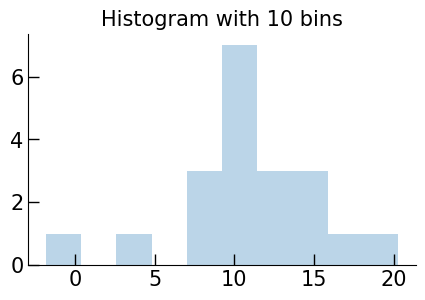

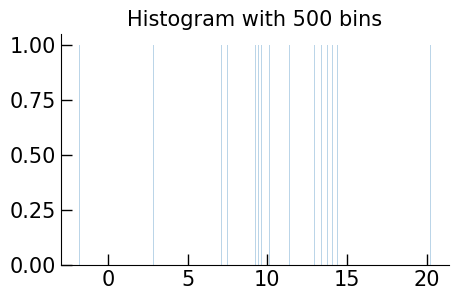

In [261]:
def sample_data(loc:float=10., scale:float=5., n:int=100, seed: int=99) -> np.array:
    """ sample data with """
    r = norm.rvs(loc=loc, scale=scale, size=n, random_state=seed)
    return r

def plot_histogram(r: np.array, bins: int = 10) -> None:
    """ """
    figsize = (5,3)
    
    fig, ax = plt.subplots(1,1, figsize=figsize)
    
    plt.hist(r, bins=bins, label='histogram', alpha=0.3)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(axis='both', which='major', direction='in', length=8, width=1, labelsize=15)
    plt.title(f'Histogram with {bins} bins', fontsize=15)
    # plt.savefig(f'./histogram_{bins}-bins.png')


SEED = 99   # random seed for reproducibility
NDATA = 20  # number of data points to be generated

# sample data    
data = sample_data(loc=10., scale=5., n = NDATA, seed=SEED)

# plot histograms 
bins_list = [10, 500] 
for bins in bins_list:
    plot_histogram(data, bins=bins)

Sturge's rule is the easiest starting point for histograms and binning - it is used to transform the data into discrete, binomial classes and assuming a normal distribution of the data

note: This assumes normally distributed data, which is not ususally the case for geospatial raster data.

**Some analytical methods require that data be normally distributed. When the data is skewed (the distribution is disproportionate), you might want to transform the data to make it normal.**

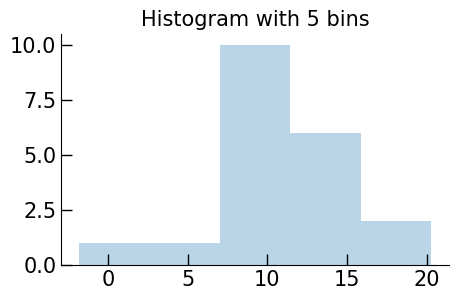

In [262]:
def sturge_optimal_bins(data: np.array) -> int:
    """ Sturge's rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    width = 1.0 + np.log2(n)
    
    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

nbins = sturge_optimal_bins(data)
plot_histogram(data, bins=nbins)

Doane’s rule is an improved version of Sturge’s rule that has a correction term related to the skewness of the distribution and therefore works better for non-normally distributed data.

Raster data tends to be non-normally distributed and rarely gives a nice gaussian distribution. So, accounting for skewness is important.

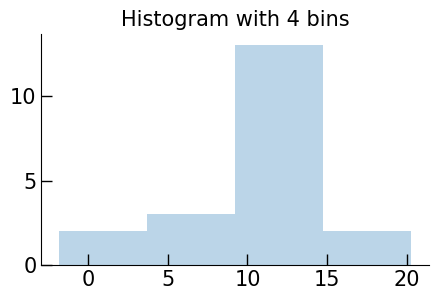

In [263]:
def doane_optimal_bins(data: np.array) -> int:
    """ Doane's rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    assert data.size > 2
    assert np.std(data) > 0
    
    n = data.size

    # coefficient
    sg1 = np.sqrt(6.0 * (n - 2.0) / ((n + 1.0) * (n + 3.0)))
    
    # skewness
    skew = np.mean(((data - np.mean(data)) / np.std(data))**3)
    
    # skewness correction
    Ke = np.log2(1.0 + np.absolute(skew)/sg1)
    
    width = 1.0 + np.log2(n) + Ke
    
    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

nbins = doane_optimal_bins(data)
plot_histogram(data, bins=nbins)

The Rice and the Square Root rules are two simple alternatives to Sturge’s rule. Both tend to overestimate the number of bins.

Logarithmic transformation is often used when the data has a positively skewed distribution and there are a few very large values.

A square root transformation is similar to a logarithmic transformation in that it reduces right skewness of a dataset. Unlike logarithmic transformations, square root transformations can be applied to zero. BUT, Square root transformations can only be applied to numbers greater than or equal to zero, so they can't be used when pixel values are negative, like NDVI.

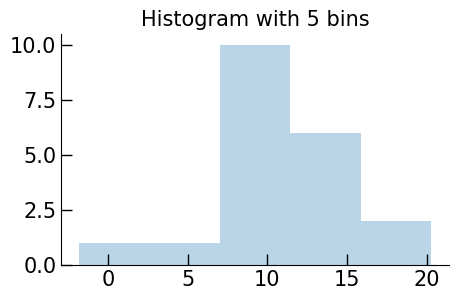

In [264]:
def rice_optimal_bins(data: np.array) -> int:
    """ The Rice rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    width = 2 * n**(1./3)
    
    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

nbins = rice_optimal_bins(data)
plot_histogram(data, bins=nbins)

In [265]:
crs = "EPSG:4326"
dem_path = '/workspace/notebooks/sandbox/data/input-data/vmelev_dem10m.tif'

output_path = '/workspace/notebooks/sandbox/data/output-data/histograms'

In [266]:
dem = rioxarray.open_rasterio(dem_path)
dem

<xarray.DataArray (band: 1, y: 557, x: 860)> Size: 2MB
[479020 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 145.2 145.2 145.2 145.2 ... 145.3 145.3 145.3
  * y            (y) float64 4kB -37.67 -37.67 -37.67 ... -37.72 -37.72 -37.72
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      elevation

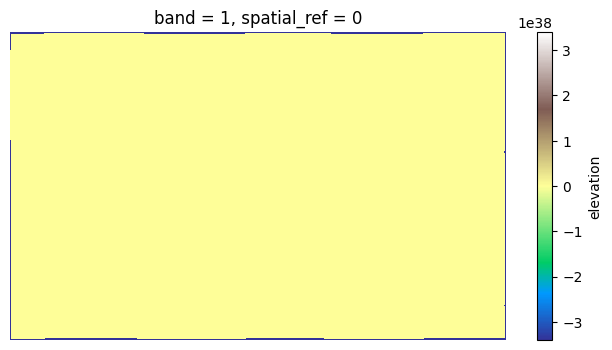

In [267]:
f, ax = plt.subplots(figsize=(8, 4))
dem.plot(cmap="terrain",
                 ax=ax)
ax.set_axis_off()
plt.show()

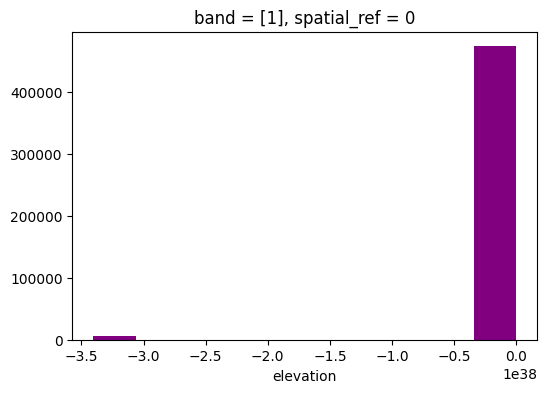

In [268]:
fig, ax = plt.subplots(figsize=(6, 4))
dem.plot.hist(ax=ax, color="purple")
plt.show()

In [269]:
print("the minimum raster value is: ", np.nanmin(dem.values))
print("the maximum raster value is: ", np.nanmax(dem.values))

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  269.3495


In [270]:
print(dem.shape)
dem = rioxarray.open_rasterio(dem_path, masked=True).squeeze()
print(dem.shape)

(1, 557, 860)
(557, 860)


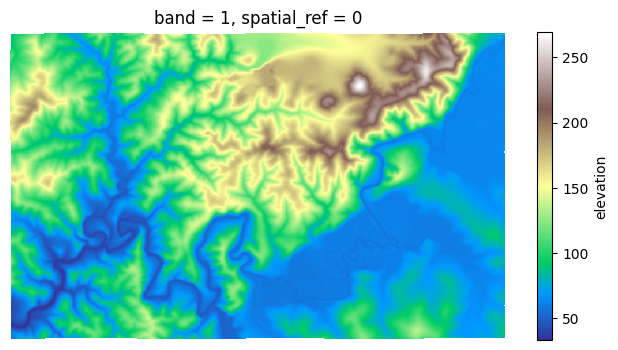

In [271]:
f, ax = plt.subplots(figsize=(8, 4))
dem.plot(cmap="terrain",
                 ax=ax)
ax.set_axis_off()
plt.show()

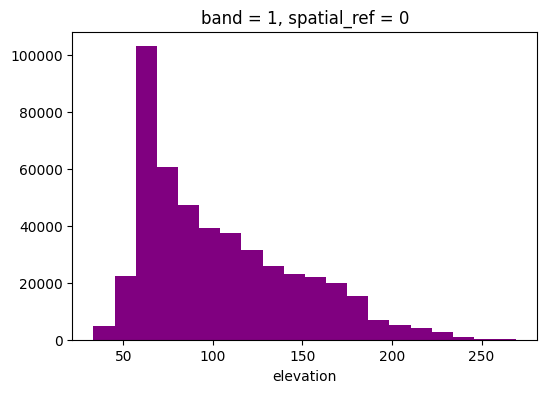

In [272]:
f, ax = plt.subplots(figsize=(6, 4))
dem.plot.hist(color="purple",
                      bins=20)
plt.show()

### Equal-width binning


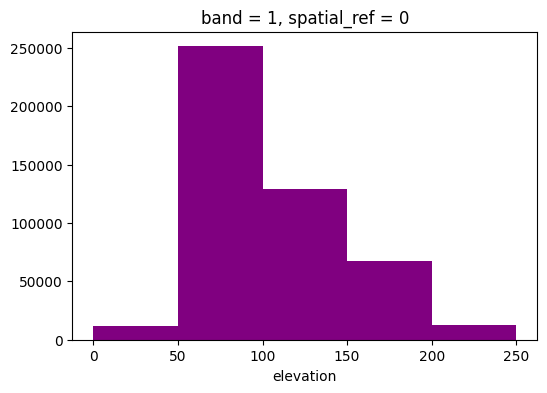

In [273]:
f, ax = plt.subplots(figsize=(6, 4))
dem.plot.hist(color="purple",
                      bins=[0,50,100,150,200,250])
plt.show()

In [274]:
# Check nodata value for your array
dem.rio.nodata

nan

In [275]:
data_min_value = np.nanmin(dem)
data_max_value = np.nanmax(dem)
print(data_min_value, data_max_value)

33.345604 269.3495


In [276]:
class_bins = [-np.inf, 0, 50, 100, 150, 200, 250, np.inf]

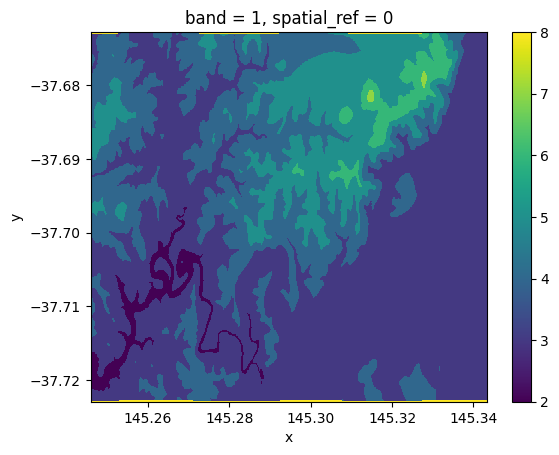

In [277]:
dem_class = xr.apply_ufunc(np.digitize,
                                     dem,
                                     class_bins)

im = dem_class.plot.imshow()
ax.set_axis_off()

In [278]:
dem_class.rio.crs

file_outpath = os.path.join(output_path, 'dem_class.tif')
dem_class.rio.to_raster(file_outpath)